https://www.kaggle.com/datasets/splcher/animefacedataset/data

In [173]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
import os
from PIL import Image

In [174]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [175]:
image_size = 64
batch_size =64
stats = (.5,.5,.5), (.5,.5,.5)

In [176]:
transform=transforms.Compose([transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize(*stats)])

In [177]:
class CustomDataset(Dataset):
    def __init__(self,image_path,transform=None):
        super().__init__()
        self.files = [os.path.join(image_path,image)
                      for image in os.listdir(image_path) if image.lower().endswith(('.png','.jpg','.jpeg'))]
        self.transorm=transform

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self,index):
        image = Image.open(self.files[index]).convert('RGB')
        if self.transorm:
            image=self.transorm(image)
        return image

In [178]:
train_dataset = CustomDataset('C:/Users/fidyt/Desktop/ML/Anime face GAN/images',transform=transform)

In [179]:
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=0,pin_memory=True)

In [180]:
import matplotlib.pyplot as plt
import random

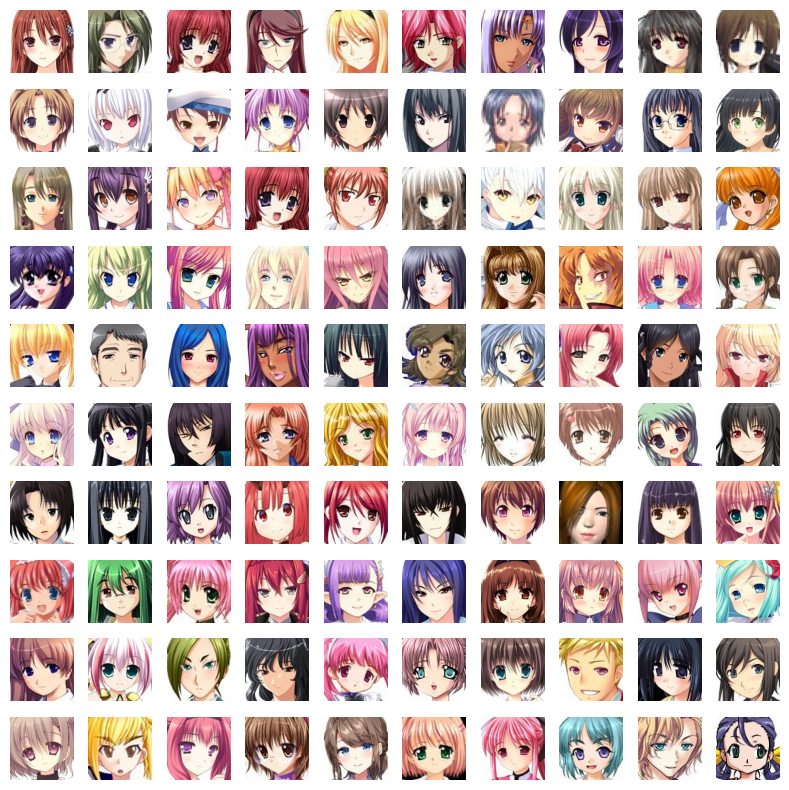

In [181]:
image_files = [os.path.join('C:/Users/fidyt/Desktop/ML/Anime face GAN/images',f) for f in os.listdir('C:/Users/fidyt/Desktop/ML/Anime face GAN/images') if f.lower().endswith(('.png','.jpg','.jpeg'))]
row,col = 10,10
f,axs = plt.subplots(row,col,figsize=(8,8))

for c in range(row):
    for r in range(col):
        image = Image.open(random.choice(image_files)).convert('RGB')
        axs[c,r].imshow(image)
        axs[c,r].axis('off')
plt.tight_layout()

In [182]:
for x in train_dataset:
    print(x.shape)
    break

torch.Size([3, 64, 64])


In [183]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential=nn.Sequential(
            nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(.2,inplace=True),

            nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(.2,inplace=True),
            
            nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(.2,inplace=True),

            nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(.2,inplace=True),

            nn.Conv2d(512,1,kernel_size=4,stride=1,padding=0,bias=False),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten()
            )
    def forward(self,x):
        x = self.sequential(x)
        return x

In [184]:
discriminator = Discriminator().to(device)

In [185]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.ConvTranspose2d(128,512,kernel_size=4,stride=1,padding=0,bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64,3,kernel_size=4,stride=2,padding=1,bias=False),
            nn.Tanh()
        )

    def forward(self,x):
        x=self.sequential(x)
        return x

In [186]:
generator=Generator().to(device)

latent_vector = torch.randn(5,128,1,1,device=device)

(np.float64(-0.5), np.float64(133.5), np.float64(199.5), np.float64(-0.5))

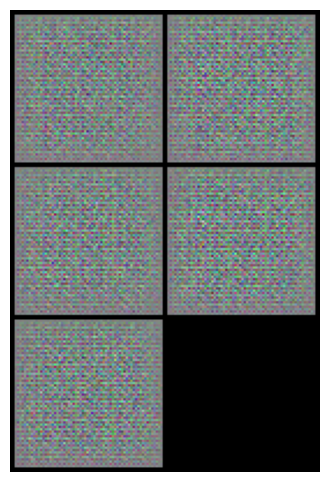

In [187]:
import torchvision.utils as vutils

with torch.no_grad():
    generator.eval()
    fake_images = generator(latent_vector)

grid = vutils.make_grid(fake_images,nrow=3,normalize=True).cpu()
plt.figure(figsize=(12,6))
plt.imshow(grid.permute(2,1,0))
plt.axis('off')

In [188]:
EPOCHS  =20
LR = 0.0002

In [189]:
from torch.optim import Adam
from tqdm import tqdm

In [190]:
criterion = nn.BCEWithLogitsLoss()
optimizerD=Adam(discriminator.parameters(),lr=LR,betas=(0.5,0.999))
optimizerG=Adam(generator.parameters(),lr=LR,betas=(0.5,0.999))


In [191]:
for epoch in range(EPOCHS):
    generator.train()
    discriminator.train()
    for real_image in tqdm(train_dataloader,desc='Training'):
        real_image=real_image.to(device)
        batch_size = real_image.size(0)

        real_labels = torch.ones(batch_size,1,device=device) *0.9
        fake_labels = torch.zeros(batch_size,1,device=device)
        #update discriminator
        optimizerD.zero_grad()

        real_outputs = discriminator(real_image)
        real_loss =criterion(real_outputs,real_labels)

        z=torch.randn(batch_size,128,1,1,device=device)
        fake_image = generator(z)
        fake_ouputs = discriminator(fake_image.detach())
        fake_loss = criterion(fake_ouputs,fake_labels)

        lossD = real_loss+fake_loss
        lossD.backward()
        optimizerD.step()

        #update gen

        optimizerG.zero_grad()
        fake_ouputs=discriminator(fake_image)
        lossG = criterion(fake_ouputs,real_labels)
        lossG.backward()
        optimizerG.step()
    if epoch % 2 == 0:
        print(f'Epoch:{epoch}/{EPOCHS}, Loss D: {lossD.item():.3f} , Loss G: {lossG.item()}')

Training: 100%|██████████| 994/994 [00:51<00:00, 19.19it/s]


Epoch:0/20, Loss D: 0.711 , Loss G: 3.315732717514038


Training: 100%|██████████| 994/994 [00:49<00:00, 20.28it/s]


Epoch:2/20, Loss D: 0.876 , Loss G: 9.488506317138672


Training: 100%|██████████| 994/994 [00:52<00:00, 18.96it/s]


Epoch:4/20, Loss D: 0.729 , Loss G: 2.1885616779327393


Training: 100%|██████████| 994/994 [00:56<00:00, 17.75it/s]


Epoch:6/20, Loss D: 0.485 , Loss G: 2.950568675994873


Training: 100%|██████████| 994/994 [00:49<00:00, 20.24it/s]


Epoch:8/20, Loss D: 0.621 , Loss G: 0.6408511400222778


Training: 100%|██████████| 994/994 [00:53<00:00, 18.67it/s]


Epoch:10/20, Loss D: 0.544 , Loss G: 1.7283631563186646


Training: 100%|██████████| 994/994 [00:53<00:00, 18.71it/s]


Epoch:12/20, Loss D: 0.358 , Loss G: 5.437244892120361


Training: 100%|██████████| 994/994 [00:51<00:00, 19.13it/s]


Epoch:14/20, Loss D: 0.379 , Loss G: 3.943793296813965


Training: 100%|██████████| 994/994 [00:52<00:00, 19.00it/s]


Epoch:16/20, Loss D: 0.396 , Loss G: 5.217493534088135


Training: 100%|██████████| 994/994 [00:53<00:00, 18.73it/s]


Epoch:18/20, Loss D: 0.456 , Loss G: 5.522100925445557


Training: 100%|██████████| 994/994 [00:52<00:00, 18.83it/s]


In [192]:
torch.save(generator.state_dict(),'generator.pth')
torch.save(discriminator.state_dict(),'discriminator.pth')

In [193]:
print(real_outputs.shape,real_labels.shape,fake_ouputs.shape,fake_labels.shape)

torch.Size([13, 1]) torch.Size([13, 1]) torch.Size([13, 1]) torch.Size([13, 1])


(np.float64(-0.5), np.float64(265.5), np.float64(265.5), np.float64(-0.5))

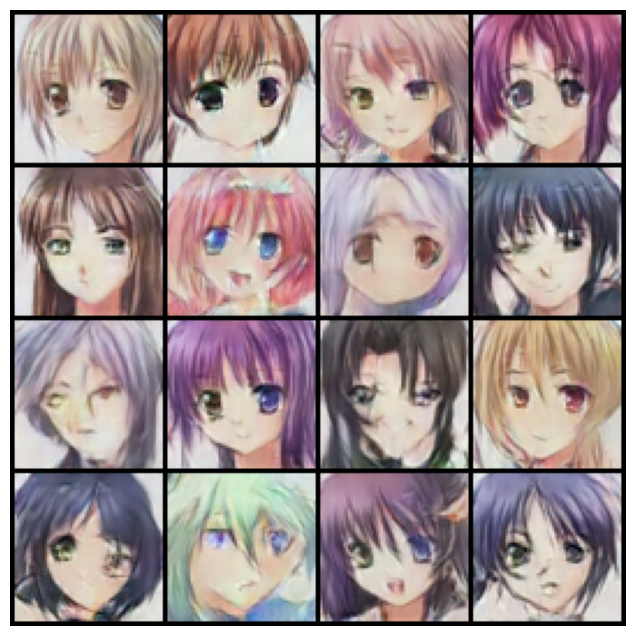

In [222]:
generator.eval()
generator.to(device)
batch_size=16
latent_dim=128
z=torch.randn(batch_size,128,1,1,device=device)

with torch.no_grad():
    generated_images=generator(z)


generated_images = (generated_images+1)/2
generated_images    =generated_images.cpu()

grid = vutils.make_grid(generated_images,nrow=4,normalize=True)
plt.figure(figsize=(8,8))
plt.imshow(grid.permute(1,2,0).cpu())
plt.axis('off')
